In [22]:
import os
import time
import copy
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report




In [23]:
import os

CSV_PATH = "/Users/basar/Desktop/CS412_HW/CelebA30k.csv"
IMAGE_ROOT = "/Users/basar/Desktop/CS412_HW/CelebA30k"

IMAGE_COL = "filename"   
TARGET_COL = "Smiling"

BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 1e-4
RANDOM_STATE = 42

print("Working directory:", os.getcwd())
print("CSV exists?      ", os.path.exists(CSV_PATH))
print("Image folder exists?", os.path.exists(IMAGE_ROOT))


Working directory: /Users/basar/Desktop/CS412_HW
CSV exists?       True
Image folder exists? True


In [25]:
# Load CelebA attribute CSV
df = pd.read_csv(CSV_PATH)

print("Columns:", df.columns.tolist())
print("Number of rows:", len(df))
display(df.head())

# Convert 'Smiling' from {-1, 1} to {0, 1} if needed
unique_vals = set(df[TARGET_COL].unique())
print("Unique label values before conversion:", unique_vals)

if unique_vals == {-1, 1} or unique_vals == {1, -1}:
    df[TARGET_COL] = (df[TARGET_COL] == 1).astype(int)

print("\nLabel distribution (after conversion):")
print(df[TARGET_COL].value_counts())


Columns: ['filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Number of rows: 30000


,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Unique label values before conversion: {np.int64(1), np.int64(-1)}

Label distribution (after conversion):
Smiling
0    15741
1    14259
Name: count, dtype: int64


In [26]:
# 80 / 10 / 10 stratified split
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=df[TARGET_COL]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=temp_df[TARGET_COL]
)

print("Train size:", len(train_df))
print("Val size  :", len(val_df))
print("Test size :", len(test_df))

print("\nLabel distribution (train):")
print(train_df[TARGET_COL].value_counts(normalize=True))
print("\nLabel distribution (val):")
print(val_df[TARGET_COL].value_counts(normalize=True))
print("\nLabel distribution (test):")
print(test_df[TARGET_COL].value_counts(normalize=True))


Train size: 24000
Val size  : 3000
Test size : 3000

Label distribution (train):
Smiling
0    0.524708
1    0.475292
Name: proportion, dtype: float64

Label distribution (val):
Smiling
0    0.524667
1    0.475333
Name: proportion, dtype: float64

Label distribution (test):
Smiling
0    0.524667
1    0.475333
Name: proportion, dtype: float64


In [6]:
class CelebASmileDataset(Dataset):
    def __init__(self, dataframe, image_root, image_col, target_col, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_root = image_root
        self.image_col = image_col
        self.target_col = target_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_root, str(row[self.image_col]))
        image = Image.open(img_path).convert("RGB")
        label = int(row[self.target_col])

        if self.transform is not None:
            image = self.transform(image)

        # BCEWithLogitsLoss expects float targets
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


In [7]:
# ImageNet normalization for VGG-16
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# No augmentation for validation & test
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_dataset = CelebASmileDataset(train_df, IMAGE_ROOT, IMAGE_COL, TARGET_COL, transform=train_transform)
val_dataset   = CelebASmileDataset(val_df,   IMAGE_ROOT, IMAGE_COL, TARGET_COL, transform=eval_transform)
test_dataset  = CelebASmileDataset(test_df,  IMAGE_ROOT, IMAGE_COL, TARGET_COL, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

dataloaders = {"train": train_loader, "val": val_loader}


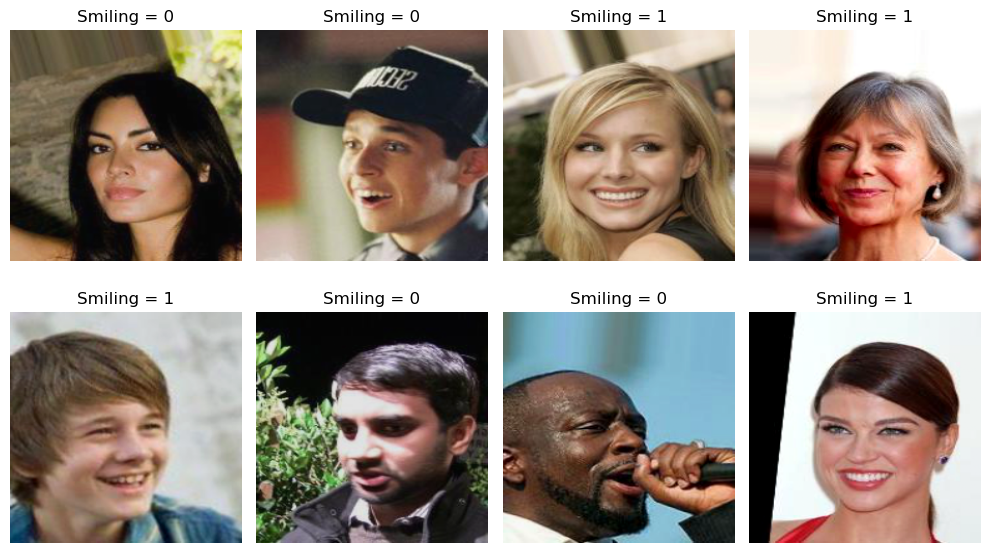

In [9]:
def imshow_tensor(img_tensor, title=None):
    img = img_tensor.clone().detach().cpu()
    img = img * torch.tensor(imagenet_std).view(3, 1, 1) + torch.tensor(imagenet_mean).view(3, 1, 1)
    img = img.clamp(0, 1)
    npimg = img.permute(1, 2, 0).numpy()
    plt.imshow(npimg)
    if title is not None:
        plt.title(title)
    plt.axis("off")

batch_images, batch_labels = next(iter(train_loader))
plt.figure(figsize=(10, 6))
for i in range(min(8, batch_images.size(0))):
    plt.subplot(2, 4, i + 1)
    imshow_tensor(batch_images[i])
    plt.title(f"Smiling = {int(batch_labels[i].item())}")
plt.tight_layout()
plt.show()


In [10]:
def create_vgg16_model(fine_tune_last_block=False):
    """
    Create a VGG-16 model for binary smiling classification.

    fine_tune_last_block = False:
        Freeze all convolutional layers and train only the classifier head.
    fine_tune_last_block = True:
        Unfreeze the last convolutional block (conv5_x) and the classifier head.
    """
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Freeze all parameters
    for param in vgg.parameters():
        param.requires_grad = False

    if fine_tune_last_block:
        # Unfreeze last conv block: layers 24–30 in vgg.features
        for layer in vgg.features[24:]:
            for param in layer.parameters():
                param.requires_grad = True

    # Replace classifier head with a binary output (single logit)
    in_features = vgg.classifier[-1].in_features
    vgg.classifier[-1] = nn.Linear(in_features, 1)

    return vgg


In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device="cpu", model_name="model"):
    since = time.time()

    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    probs = torch.sigmoid(outputs)
                    preds = (probs >= 0.5).float()

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()
                running_samples += labels.size(0)

            epoch_loss = running_loss / running_samples
            epoch_acc = running_corrects / running_samples

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history, best_val_acc, time_elapsed


In [12]:
def plot_training_curves(history, title_suffix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss{title_suffix}")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy{title_suffix}")
    plt.legend()

    plt.tight_layout()
    plt.show()


def evaluate_on_loader(model, data_loader, device="cpu"):
    model.eval()
    model.to(device)

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).view(-1)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    cm = confusion_matrix(all_labels, all_preds)
    acc = (all_labels == all_preds).mean()

    return acc, cm, all_labels, all_preds, all_probs


def plot_confusion_matrix(cm, class_names=("Not Smiling", "Smiling"), title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    plt.show()


=== Experiment 1: Frozen convolutional layers (feature extractor) ===
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/basar/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [01:40<00:00, 5.48MB/s]  


Epoch 1/10
--------------------
train Loss: 0.6271 Acc: 0.6471
val Loss: 0.5831 Acc: 0.7143

Epoch 2/10
--------------------
train Loss: 0.5782 Acc: 0.7010
val Loss: 0.5608 Acc: 0.7207

Epoch 3/10
--------------------
train Loss: 0.5659 Acc: 0.7119
val Loss: 0.5518 Acc: 0.7227

Epoch 4/10
--------------------
train Loss: 0.5569 Acc: 0.7126
val Loss: 0.5475 Acc: 0.7213

Epoch 5/10
--------------------
train Loss: 0.5511 Acc: 0.7202
val Loss: 0.5379 Acc: 0.7397

Epoch 6/10
--------------------
train Loss: 0.5481 Acc: 0.7205
val Loss: 0.5405 Acc: 0.7267

Epoch 7/10
--------------------
train Loss: 0.5469 Acc: 0.7220
val Loss: 0.5322 Acc: 0.7430

Epoch 8/10
--------------------
train Loss: 0.5425 Acc: 0.7231
val Loss: 0.5331 Acc: 0.7377

Epoch 9/10
--------------------
train Loss: 0.5417 Acc: 0.7247
val Loss: 0.5272 Acc: 0.7453

Epoch 10/10
--------------------
train Loss: 0.5420 Acc: 0.7248
val Loss: 0.5276 Acc: 0.7417

Training complete in 74m 35s
Best val Acc: 0.7453


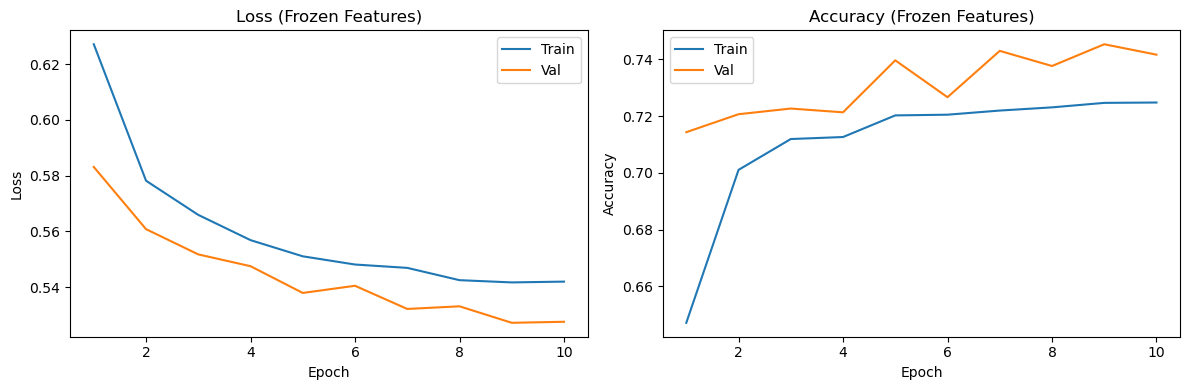

In [13]:
print("=== Experiment 1: Frozen convolutional layers (feature extractor) ===")

model_frozen = create_vgg16_model(fine_tune_last_block=False)
criterion = nn.BCEWithLogitsLoss()

optimizer_frozen = optim.Adam(
    filter(lambda p: p.requires_grad, model_frozen.parameters()),
    lr=LR,
)

model_frozen, history_frozen, best_val_acc_frozen, time_frozen = train_model(
    model_frozen,
    dataloaders,
    criterion,
    optimizer_frozen,
    num_epochs=NUM_EPOCHS,
    device=device,
    model_name="frozen",
)

plot_training_curves(history_frozen, title_suffix=" (Frozen Features)")


Test accuracy (frozen features): 0.7430


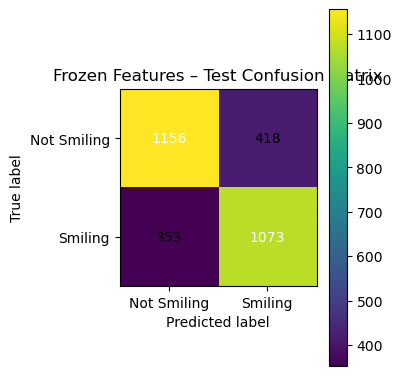


Classification report (frozen features):
              precision    recall  f1-score   support

 Not Smiling       0.77      0.73      0.75      1574
     Smiling       0.72      0.75      0.74      1426

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.74      0.74      0.74      3000



In [14]:
test_acc_frozen, cm_frozen, y_true_frozen, y_pred_frozen, y_prob_frozen = evaluate_on_loader(
    model_frozen, test_loader, device=device
)

print(f"Test accuracy (frozen features): {test_acc_frozen:.4f}")
plot_confusion_matrix(cm_frozen, title="Frozen Features – Test Confusion Matrix")

print("\nClassification report (frozen features):")
print(classification_report(y_true_frozen, y_pred_frozen, target_names=["Not Smiling", "Smiling"]))


=== Experiment 2: Fine-tuning last convolutional block ===
Epoch 1/10
--------------------
train Loss: 0.2920 Acc: 0.8697
val Loss: 0.2216 Acc: 0.9103

Epoch 2/10
--------------------
train Loss: 0.2074 Acc: 0.9131
val Loss: 0.1911 Acc: 0.9150

Epoch 3/10
--------------------
train Loss: 0.1833 Acc: 0.9238
val Loss: 0.1845 Acc: 0.9237

Epoch 4/10
--------------------
train Loss: 0.1664 Acc: 0.9303
val Loss: 0.1813 Acc: 0.9240

Epoch 5/10
--------------------
train Loss: 0.1449 Acc: 0.9397
val Loss: 0.1912 Acc: 0.9223

Epoch 6/10
--------------------
train Loss: 0.1278 Acc: 0.9472
val Loss: 0.2162 Acc: 0.9170

Epoch 7/10
--------------------
train Loss: 0.0996 Acc: 0.9591
val Loss: 0.2241 Acc: 0.9220

Epoch 8/10
--------------------
train Loss: 0.0803 Acc: 0.9685
val Loss: 0.2285 Acc: 0.9190

Epoch 9/10
--------------------
train Loss: 0.0670 Acc: 0.9745
val Loss: 0.2634 Acc: 0.9080

Epoch 10/10
--------------------
train Loss: 0.0455 Acc: 0.9827
val Loss: 0.2897 Acc: 0.9183

Training c

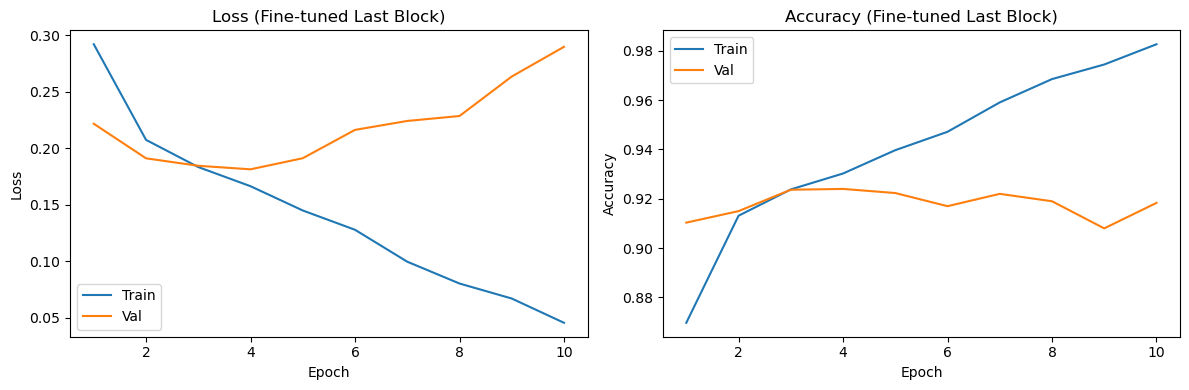

In [15]:
print("=== Experiment 2: Fine-tuning last convolutional block ===")

model_ft = create_vgg16_model(fine_tune_last_block=True)
criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=LR,
)

model_ft, history_ft, best_val_acc_ft, time_ft = train_model(
    model_ft,
    dataloaders,
    criterion,
    optimizer_ft,
    num_epochs=NUM_EPOCHS,
    device=device,
    model_name="fine_tuned",
)

plot_training_curves(history_ft, title_suffix=" (Fine-tuned Last Block)")


Test accuracy (fine-tuned last block): 0.9230


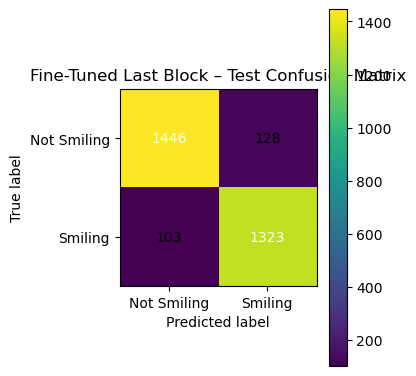


Classification report (fine-tuned last block):
              precision    recall  f1-score   support

 Not Smiling       0.93      0.92      0.93      1574
     Smiling       0.91      0.93      0.92      1426

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [16]:
test_acc_ft, cm_ft, y_true_ft, y_pred_ft, y_prob_ft = evaluate_on_loader(
    model_ft, test_loader, device=device
)

print(f"Test accuracy (fine-tuned last block): {test_acc_ft:.4f}")
plot_confusion_matrix(cm_ft, title="Fine-Tuned Last Block – Test Confusion Matrix")

print("\nClassification report (fine-tuned last block):")
print(classification_report(y_true_ft, y_pred_ft, target_names=["Not Smiling", "Smiling"]))


In [17]:
results_table = pd.DataFrame({
    "Setting": ["Frozen features", "Fine-tuned last block"],
    "Best Val Acc": [best_val_acc_frozen, best_val_acc_ft],
    "Test Acc": [test_acc_frozen, test_acc_ft],
    "Training Time (s)": [time_frozen, time_ft],
})

results_table


,Setting,Best Val Acc,Test Acc,Training Time (s)
0,Frozen features,0.745333,0.743,4475.042734
1,Fine-tuned last block,0.924000,0.923,13965.288838


Using fine-tuned model for visualization.


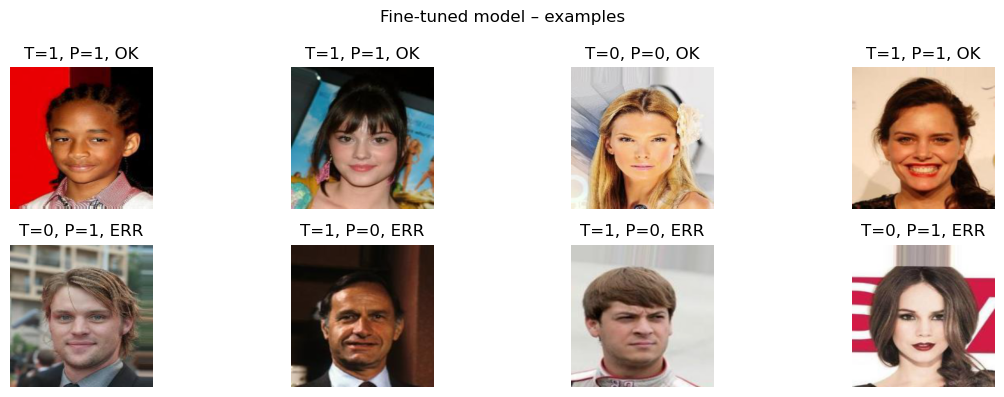

In [18]:
def show_examples(dataset, labels_true, labels_pred, title, max_images=8):
    indices = np.arange(len(labels_true))
    selected = []

    for correct in [True, False]:
        if correct:
            idxs = indices[labels_true == labels_pred]
        else:
            idxs = indices[labels_true != labels_pred]

        np.random.shuffle(idxs)
        for i in idxs[: max_images // 2]:
            selected.append((i, correct))

    plt.figure(figsize=(12, 4))
    for i, (idx, correct) in enumerate(selected):
        img, label = dataset[idx]
        plt.subplot(2, len(selected) // 2, i + 1)
        imshow_tensor(img)
        pred = int(labels_pred[idx])
        true = int(labels_true[idx])
        plt.title(f"T={true}, P={pred}, {'OK' if correct else 'ERR'}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


if best_val_acc_ft >= best_val_acc_frozen:
    print("Using fine-tuned model for visualization.")
    show_examples(test_dataset, y_true_ft, y_pred_ft, title="Fine-tuned model – examples")
else:
    print("Using frozen-features model for visualization.")
    show_examples(test_dataset, y_true_frozen, y_pred_frozen, title="Frozen-features model – examples")


In [ ]:
## Discussion

### Impact of Data Augmentation
- Which augmentation techniques were used?
- Why are random horizontal flip and small color jitter reasonable for this task?
- How do you expect them to affect generalization?

### Transfer Learning vs Fine-Tuning
- Compare validation and test accuracies of the frozen-features and fine-tuned models.
- Discuss any overfitting / underfitting indications from the loss and accuracy curves.
- Comment on training time and computational cost.

### Typical Classification Errors
- What kinds of images are often misclassified (pose, lighting, occlusions, ambiguous smiles, etc.)?
- How do these errors relate to model capacity and dataset limitations?

### Final Model Choice
- Which configuration do you select as the final model?
- What is its final test accuracy?
- Why is this setup the best for this task?
